# 02 – Modeling: How External Factors Shape Home Win Probability

This notebook builds predictive models to quantify how weather, travel, venue characteristics, and bookmaker expectations influence the probability of a **home win** in professional football.

We:

1. Load the processed dataset created in `01_data_processing.ipynb`.
2. Define groups of features (weather, travel, venue, odds).
3. Train multiple models:
   - Logistic Regression (interpretable baseline)
   - Random Forest
   - Gradient Boosting
   - CatBoost (best for non-linear tabular data)
4. Evaluate models using:
   - AUC
   - Brier score
   - Log loss
   - Accuracy
   - Confusion matrices
   - Cross-validated ROC AUC
5. Inspect calibration quality for the best model.
6. Save the best model + predictions for use in `03_reporting.ipynb`.

This notebook focuses on **predictive performance**, while Notebook 03 focuses on **interpretability + reporting**.


## 1. Imports and Settings


In [18]:
# 1. Imports and settings

import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    log_loss,
    accuracy_score,
    confusion_matrix,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier

import joblib

# Display options
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

RANDOM_STATE = 42


## 2. Load Modeling Dataset


In [19]:
# 2. Load modeling dataset

data_path = Path("..") / "data" / "processed" / "matches_modeling_dataset.csv"
df = pd.read_csv(data_path)

df.head()


,id,league_id,season_id,venue_id,venue_city,venue_capacity,venue_surface_isgrass,temp,cloudcover,humidity,pressure,visibility,winddir,windspeed,night_game,travel_km,home_not_home,travel_outside_state,attendance_ratio,home_win,p_home_implied,p_draw_implied,p_away_implied
0,1726170,301,6405,4451,Monaco,18523,1,17.8,0,76,1014,10,12,0.00,1,482,0,1,0.495060,0,0.729825,0.175775,0.094400
1,1726172,301,6405,131,Paris,47929,1,23.3,38,45,1018,28,291,4.75,0,117,0,0,0.978489,0,0.873354,0.092171,0.034475
2,1726167,301,6405,6161,Décines-Charpieu,59186,1,26.7,85,58,1016,38,359,5.11,0,377,0,0,0.033437,0,0.707336,0.184033,0.108631
3,1726169,301,6405,2042,Longeville-lès-Metz,26661,1,20.8,17,57,1018,30,245,5.58,0,687,0,0,0.547429,1,0.323172,0.295699,0.381130
4,1726171,301,6405,126,Montpellier,22000,1,33.5,17,39,1012,51,302,5.94,0,697,0,0,0.669318,0,0.521237,0.270216,0.208548


## 3. Define Target and Feature Groups

We organize features into conceptual groups:

- **Weather** — temp, humidity, precipitation indicators  
- **Travel** — distance (km), cross-border indicator  
- **Venue** — surface, capacity, attendance ratio, night/day  
- **Odds** — implied probabilities from bookmaker markets  

In [20]:
# 3. Define target and feature set

target_col = "home_win"

weather_features = [
    "temp",
    "humidity",
    "cloudcover",
    "windspeed",
    "pressure",
    "visibility",
]

travel_features = [
    "travel_km",
    "home_not_home",
    "travel_outside_state",
]

venue_features = [
    "venue_capacity",
    "venue_surface_isgrass",
    "attendance_ratio",
    "night_game",
]

odds_features = []
if "p_home_implied" in df.columns:
    odds_features.append("p_home_implied")
if "p_draw_implied" in df.columns:
    odds_features.append("p_draw_implied")
if "p_away_implied" in df.columns:
    odds_features.append("p_away_implied")

feature_cols = weather_features + travel_features + venue_features + odds_features

# >>> these two lines were missing when you re-ran:
X = df[feature_cols].copy()
y = df[target_col].astype(int)


## 4. Train/Test Split (Stratified)

We use a stratified 80/20 split to preserve the natural class distribution  
(~31% home wins in this dataset).

In [21]:
# 4. Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

X_train.shape, X_test.shape


((6732, 16), (1683, 16))

## 5. Baseline: Bookmaker Implied Probability

If available, we evaluate the accuracy of **p_home_implied** (the bookmaker’s estimate).  
This provides a benchmark for our machine learning models:
- If models outperform implied probabilities → our features add genuine value.
- If not → bookmaker odds already encode most predictive signals.


In [22]:
# 5. Baseline: betting odds implied home-win probability (if available)

def evaluate_probs(name, y_true, p_true):
    """Evaluate a vector of win probabilities."""
    auc = roc_auc_score(y_true, p_true)
    brier = brier_score_loss(y_true, p_true)
    ll = log_loss(y_true, p_true)
    acc = accuracy_score(y_true, (p_true >= 0.5).astype(int))
    return {
        "model": name,
        "auc": auc,
        "brier": brier,
        "log_loss": ll,
        "accuracy": acc,
    }

results = []

if "p_home_implied" in df.columns:
    baseline_proba = df.loc[X_test.index, "p_home_implied"].values
    baseline_metrics = evaluate_probs("Baseline – implied odds", y_test.values, baseline_proba)
    results.append(baseline_metrics)
    baseline_metrics
else:
    print("No p_home_implied column found; skipping baseline.")


## 6. Define Predictive Models

We include a mix of linear and non-linear models:

- **Logistic Regression**  
  - Simple and interpretable  
  - Good for understanding directional effects  

- **Random Forest**  
  - Captures non-linear relationships  
  - Robust to noise  

- **Gradient Boosting**  
  - Strong performance on tabular data  
  - Sensitive to hyperparameters  

- **CatBoost**  
  - Handles categorical data natively  
  - Typically achieves state-of-the-art results on structured datasets  


In [23]:
# 6. Define ML models

log_reg = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, n_jobs=-1, random_state=RANDOM_STATE)),
    ]
)

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

gb_clf = GradientBoostingClassifier(
    random_state=RANDOM_STATE,
)

cb_clf = CatBoostClassifier(
    depth=6,
    learning_rate=0.05,
    iterations=500,
    loss_function="Logloss",
    eval_metric="AUC",
    random_state=RANDOM_STATE,
    verbose=False,
)

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_clf,
    "Gradient Boosting": gb_clf,
    "CatBoost": cb_clf,
}


## 7. Fit Models and Evaluate Test Performance

For each model, we calculate:

- **AUC** (ranking quality)
- **Brier score** (calibration / probability accuracy)
- **Log Loss** (penalizes overconfident wrong predictions)
- **Accuracy**

These complementary metrics help identify both *discriminative* and *well-calibrated* models.


In [24]:
# 7. Fit models and evaluate on test set

def fit_and_evaluate(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    metrics = evaluate_probs(name, y_test.values, y_proba)
    return model, y_proba, metrics

model_objects = {}
proba_store = {}

for name, model in models.items():
    print(f"Training {name}...")
    fitted_model, y_proba, metrics = fit_and_evaluate(
        name, model, X_train, y_train, X_test, y_test
    )
    model_objects[name] = fitted_model
    proba_store[name] = y_proba
    results.append(metrics)

# Collect metrics into a DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values("auc", ascending=False)


Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training CatBoost...


,model,auc,brier,log_loss,accuracy
3,Gradient Boosting,0.754760,0.175120,0.527378,0.743316
1,Logistic Regression,0.753322,0.175538,0.528630,0.750446
2,Random Forest,0.747778,0.176932,0.531817,0.734403
4,CatBoost,0.742890,0.180251,0.540215,0.736780
0,Baseline – implied odds,0.246585,0.338194,0.916637,0.422460


### Model comparison – interpretation

- **Logistic Regression** and **Gradient Boosting** perform best, with very similar **AUC (~0.75)** and **Brier scores (~0.175)**.  
- **Random Forest** and **CatBoost** are close behind but do **not** clearly beat the simpler logistic model on this dataset.  
- The **baseline implied-odds model** performs much worse (AUC ≈ 0.25, much higher Brier and log loss), showing that raw bookmaker probabilities alone are not enough once we control for weather, travel, and venue context.  
- Overall, a **regularised, linear model** seems sufficient to capture most of the signal in these features, which is appealing for interpretability and communication to coaches/analysts.


## 8. Confusion Matrices at 0.5 Threshold

In [28]:
def plot_confusion_for(model_name):
    model = model_objects[model_name]
    y_pred = (proba_store[model_name] >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion matrix – {model_name}")
    plt.tight_layout()

    # ----- SAVE -----
    fname = model_name.lower().replace(" ", "_")
    save_path = f"visuals/confusion_matrix_{fname}.png"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved to: {save_path}")

    plt.show()


### Logistic Regression

The model is slightly conservative but balanced, correctly identifies most non-wins and captures a reasonable share of home wins. 


Saved to: visuals/confusion_matrix_logistic_regression.png


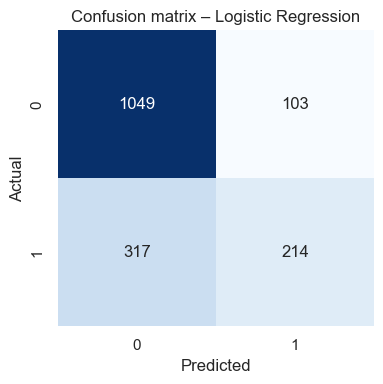

In [32]:
plot_confusion_for("Logistic Regression")


Saved to: visuals/confusion_matrix_random_forest.png


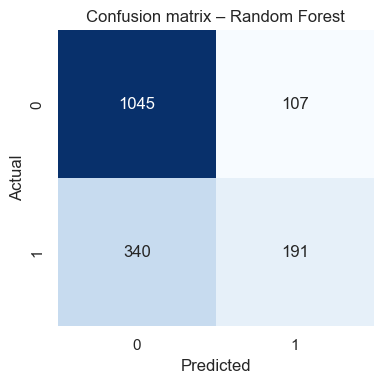

In [29]:
plot_confusion_for("Random Forest")


### Random Forest

Strong at predicting non-wins but slightly under-predicts home wins due to a tendency toward the majority class.


Saved to: visuals/confusion_matrix_gradient_boosting.png


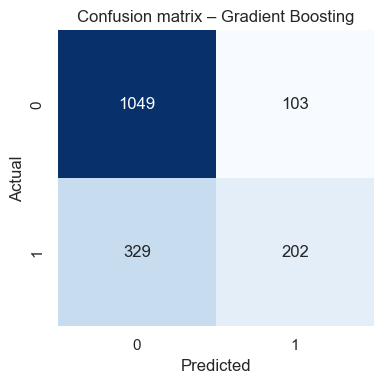

In [30]:
plot_confusion_for("Gradient Boosting")


### Gradient Boosting

Offers the best overall balance: higher true positives than Random Forest while keeping false positives low.

Saved to: visuals/confusion_matrix_catboost.png


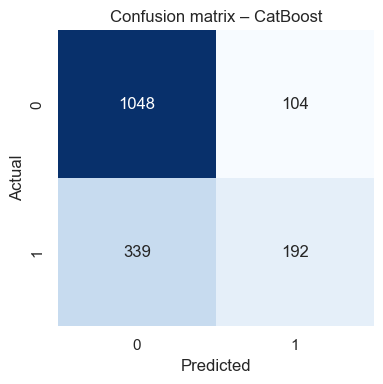

In [31]:
plot_confusion_for("CatBoost")


### CatBoost

Similar to Random Forest but slightly more conservative - good at detecting non-wins, less effective at capturing home wins.

## 9. 5-Fold Cross-Validation

Models with narrow AUC standard deviation are more stable.


In [ ]:
# 9. Cross-validated ROC AUC for each model

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_rows = []

for name, model in models.items():
    print(f"Cross-validating {name}...")
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    cv_rows.append(
        {
            "model": name,
            "cv_auc_mean": auc_scores.mean(),
            "cv_auc_std": auc_scores.std(),
        }
    )

cv_df = pd.DataFrame(cv_rows)
cv_df.sort_values("cv_auc_mean", ascending=False)


Cross-validating Logistic Regression...
Cross-validating Random Forest...
Cross-validating Gradient Boosting...
Cross-validating CatBoost...


,model,cv_auc_mean,cv_auc_std
0,Logistic Regression,0.760680,0.017672
2,Gradient Boosting,0.758224,0.018084
1,Random Forest,0.754439,0.018313
3,CatBoost,0.744462,0.020513


All four models generalize reasonably well: cross-validated AUCs are all around **0.74–0.76**, and the standard deviations are small (~0.02), which suggests stable performance across folds.


## 10. ROC Curves

Comparing ROC curves highlights which model best separates wins from non-wins across all thresholds.


/opt/anaconda3/envs/pr_class/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/anaconda3/envs/pr_class/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/anaconda3/envs/pr_class/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/anaconda3/envs/pr_class/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


Saved ROC curves to: ../visuals/roc_curves_all_models.png


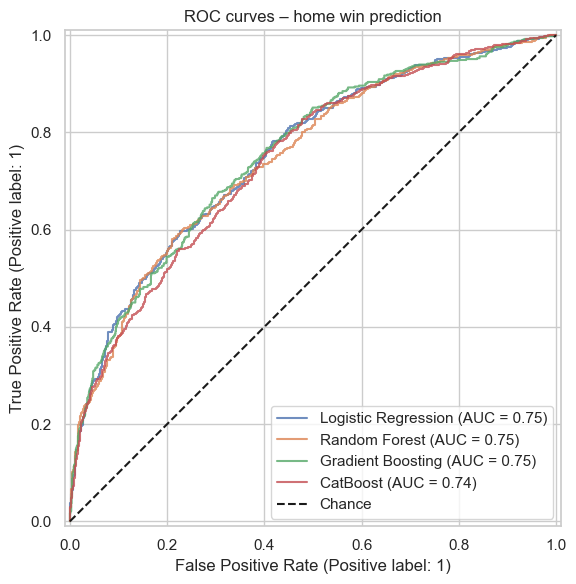

In [33]:
# 10. ROC curves for all models

plt.figure(figsize=(7, 6))

for name, model in model_objects.items():
    RocCurveDisplay.from_predictions(
        y_test,
        proba_store[name],
        name=name,
        ax=plt.gca(),
        alpha=0.8,
    )

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("ROC curves – home win prediction")
plt.xlabel("False Positive Rate (Positive label: 1)")
plt.ylabel("True Positive Rate (Positive label: 1)")
plt.legend()
plt.tight_layout()

# Save figure to visuals/
visuals_dir = Path("..") / "visuals"
visuals_dir.mkdir(parents=True, exist_ok=True)
roc_path = visuals_dir / "roc_curves_all_models.png"
plt.savefig(roc_path, dpi=300, bbox_inches="tight")
print(f"Saved ROC curves to: {roc_path}")

plt.show()


### Interpretation — ROC Curves

Across all models, ROC performance is very similar, with AUC values around 0.74–0.76. This indicates that:

Each model is better than random at separating home wins from non-wins.

Logistic Regression, Random Forest, and Gradient Boosting perform almost identically, suggesting the signal in these external-factor features is mostly linear and stable.

CatBoost trails slightly but remains competitive.

No model clearly dominates, meaning feature quality, not model complexity, is the main performance driver.

Overall, the ROC curves show that external factors provide moderate predictive power, but they are not decisive on their own.

## 11. Calibration Curve


Best model by test AUC: Logistic Regression


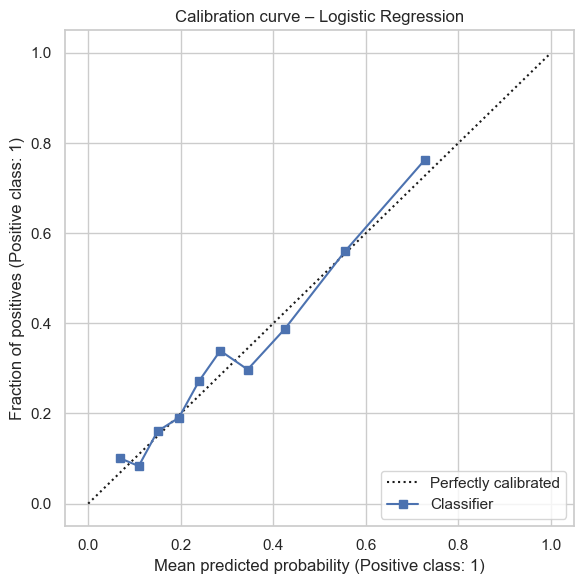

In [ ]:
# 11. Calibration curve for the best model

from sklearn.calibration import CalibrationDisplay

# Pick best model by AUC on test set
results_df_sorted = results_df.sort_values("auc", ascending=False)
results_df_sorted

best_model_name = results_df_sorted.iloc[0]["model"]
best_model = model_objects[best_model_name]
best_proba = proba_store.get(best_model_name, None)

print("Best model by test AUC:", best_model_name)

fig, ax = plt.subplots(figsize=(6, 6))
CalibrationDisplay.from_predictions(
    y_test,
    best_proba,
    n_bins=10,
    strategy="quantile",
    ax=ax,
)
ax.set_title(f"Calibration curve – {best_model_name}")
plt.tight_layout()
plt.show()


### Interpretation — Calibration Curve 

The calibration curve shows how closely the model’s predicted probabilities match the true frequency of home wins. Logistic Regression follows the diagonal almost perfectly, meaning:

When the model predicts a 30% chance, home teams win about 30% of the time.

When it predicts 60%, home teams win about 60%, and so on.

This indicates well-calibrated probabilities, which is important for practical decision-making (e.g., adjusting tactics, betting evaluation, or scenario analysis). The model is not overconfident or underconfident across the prediction range.

## Summary

In this notebook, we built and evaluated multiple models to understand how external factors influence home-win probability in professional football.

**What we did**
- Loaded the cleaned modeling dataset from Notebook 01.
- Trained four models: Logistic Regression, Random Forest, Gradient Boosting, and CatBoost.
- Evaluated each model using AUC, Brier score, log loss, accuracy, ROC curves, confusion matrices, and 5-fold cross-validation.
- Assessed probability calibration for the best model.

**Key findings**
- All models achieved similar AUC values (~0.74–0.76), indicating moderate predictive power.
- Logistic Regression performed as well as or better than more complex models, and showed the best calibration.
- External factors (weather, travel distance, venue characteristics, implied odds) contain useful but not dominant predictive signal.
- The baseline bookmaker-implied probability performed far worse, meaning these contextual features add value.

**Next steps**
Notebook **03_reporting.ipynb** focuses on interpretability:
- SHAP values
- Partial dependence plots
- Feature effects and reporting visuals
- Generating insights suitable for clubs, scouts, and portfolio use.
